## Importación de librerías

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
import random
from keras.preprocessing.image import ImageDataGenerator
import pathlib

## Carga de datasets

In [17]:
def load_dataset(folder_path):
    dataset = []
    for tag in os.listdir(folder_path):
        tag_path = os.path.join(folder_path, tag)
        if os.path.isdir(tag_path):
            for filename in os.listdir(tag_path):
                image_path = os.path.join(tag_path, filename)
                image = Image.open(image_path)
                image = np.array(image)
                dataset.append((image, tag))
    return dataset

In [18]:
train_dataset = load_dataset('seg_train/seg_train')
test_dataset = load_dataset('seg_test/seg_test')

## Preprocesamiento de datos

In [19]:
def procesar_dataset(dataset):
    # Obtener el número total de imágenes en el dataset
    num_images = len(dataset)
    print("Número total de imágenes:", num_images)

    # Obtener el número de clases únicas en el dataset
    classes = set([entry[1] for entry in dataset])
    num_classes = len(classes)
    print("Número de clases únicas:", num_classes)

    # Imprimir las clases únicas
    print("Clases únicas:", classes)

    # Mostrar algunas imágenes aleatorias del dataset
    num_samples = 5
    random_samples = random.sample(dataset, num_samples)

    plt.figure(figsize=(15, 3))

    for i, (image, tag) in enumerate(random_samples):
        # Comprobar si la imagen se cargó correctamente
        if isinstance(image, (Image.Image, np.ndarray)):
            # Mostrar la imagen si se cargó correctamente
            plt.subplot(1, num_samples, i + 1)
            plt.imshow(image)
            plt.title(tag)
            plt.axis("off")
        else:
            print(f"La imagen {image} no se cargó correctamente.")

    plt.show()

Número total de imágenes: 14034
Número de clases únicas: 6
Clases únicas: {'glacier', 'street', 'sea', 'mountain', 'forest', 'buildings'}


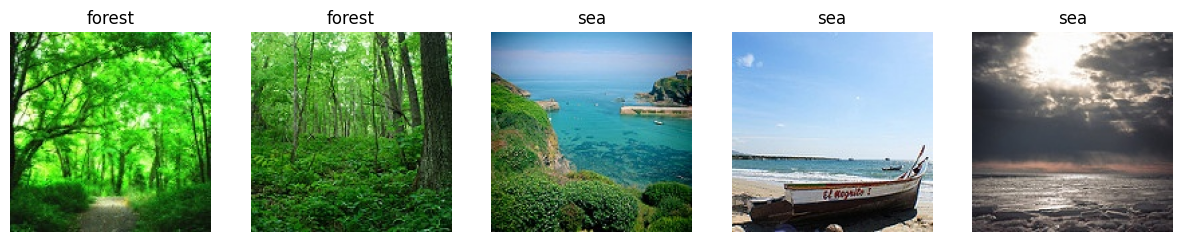

In [21]:
procesar_dataset(train_dataset)

Número total de imágenes: 3000
Número de clases únicas: 6
Clases únicas: {'glacier', 'street', 'sea', 'mountain', 'forest', 'buildings'}


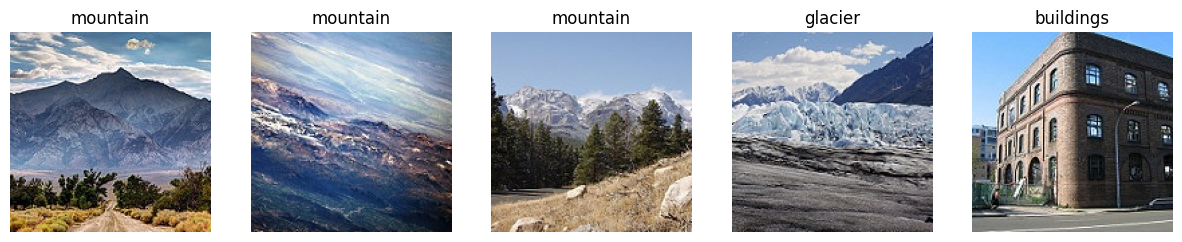

In [20]:
procesar_dataset(test_dataset)